Overfitting and Regularization
Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

Part 1: Underfitting vs. overfitting


Generate samples

Let's pick a target function  and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

Plot samples

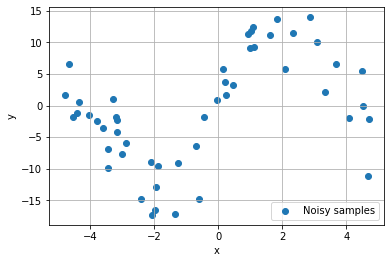

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

Split

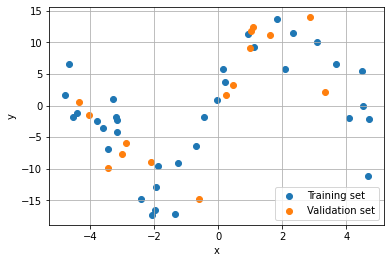

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

Model

Let's try to approximate our target function  with polynomials of different degree.


In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias= (degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

Fit

Let's fit a model and plot the hypothesis it learns:

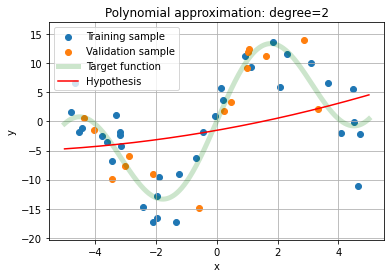

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of degree:

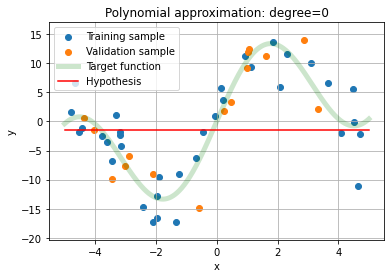

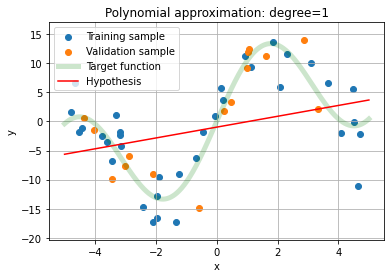

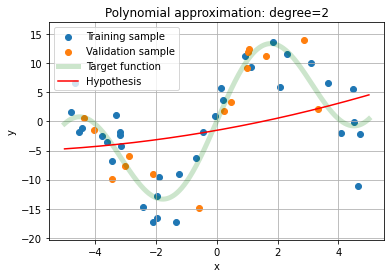

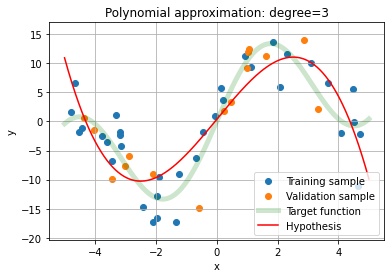

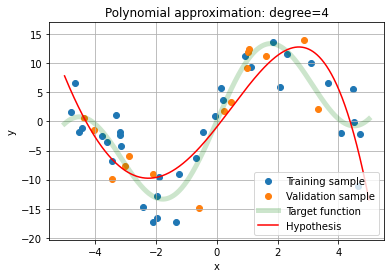

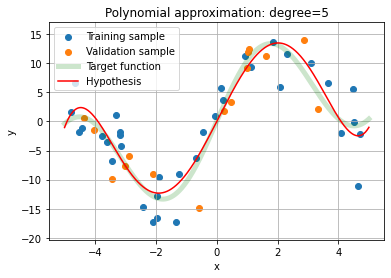

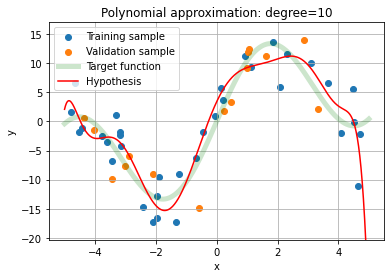

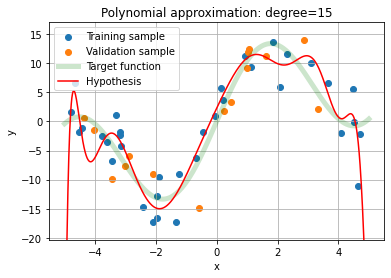

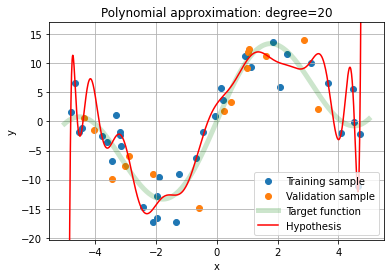

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

Fitting graph

In the next step we calculate the training and the validation error for each degree and plot them in a single graph. The resulting graph is called the fitting graph.

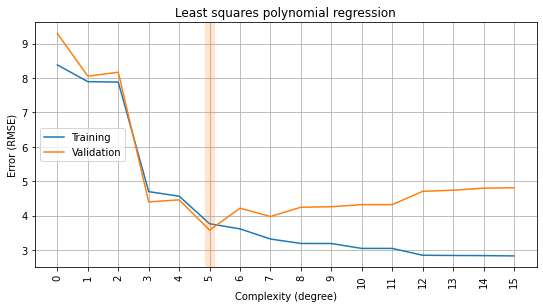

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Sweet spot\
What is the optimal degree to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

Cross-validation\
Ideally, we would choose the the model parameters such that we have the best model performance. However, we want \
to make sure that we really have the best validation performance. When we do train_test_split we randomly split \
the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation\
error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case\
is to run the experiment several times for different, random splits. However, there is an even more systematic way\
of doing this: cross-validation.

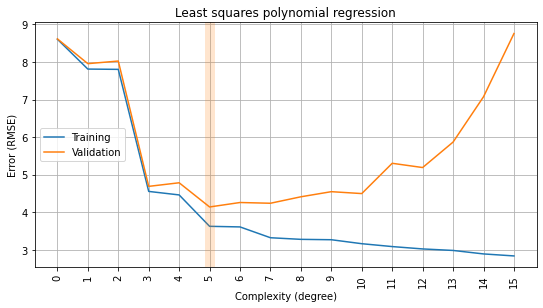

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

Model coefficients\
Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients.\

We are going to plot the mean absolute value of wi as a function of degree to reveal the relationship:

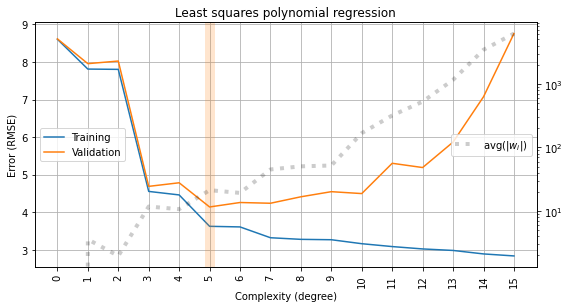

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

Summary\
We observe the following:\

Underfitting (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and \
        the validation set.\

Fit is just right (degree = 5): The model is able to capture the underlying data distribution. The fit is \
            good for both the training and the validation set.\

Overfitting (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training \
                data gets even better, the fit for the validation set gets worse.\

As the order of polynomial increases, the linear model coefficients become more likely to take on large values.\

Part 2: Regularization\
There are two major ways to build a machine learning model with the ability to generalize well on unseen data:\

Train the simplest model possible for our purpose (according to Occam’s Razor).\
Train a complex or more expressive model on the data and perform regularization.\
Regularization is a method used to reduce the variance of a machine learning model. In other words,\
                        it is used to reduce overfitting. Regularization penalizes a model for being complex.\
                        For linear models, it means regularization forces model coefficients to be smaller in \
                        magnitude.\

Let's pick a polynomial model of degree 15 (which tends to overfit strongly) and try to regularize it using L1 \
and L2 penalties.\
L1 - Lasso regression

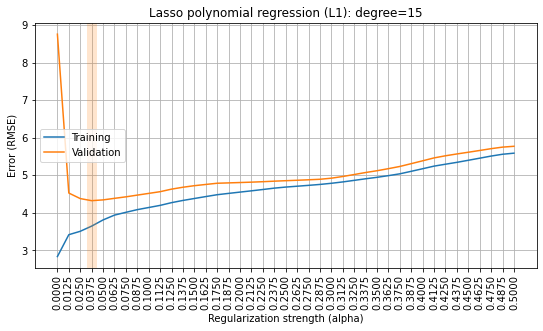

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

L2 - Ridge regression

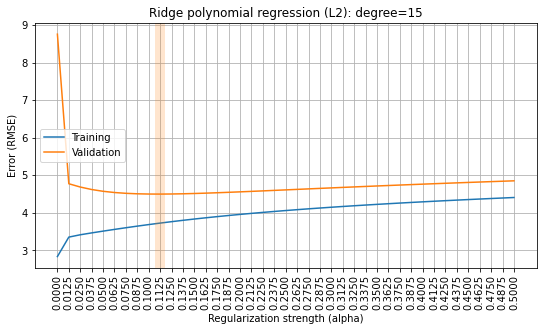

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

Summary\
We can control the regularization strength by changing the hyperparameter alpha.\
Regularized version of the model performs pretty well. Even in case the original original (unregularized)\
model is heavily overfitting due to excessive complexity.\




Part 3: Homework assignment (10 points)\
Excercise 1 - Overfiting and Underfitting (2 points)\
Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [81]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

In [82]:
DEGREES = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]

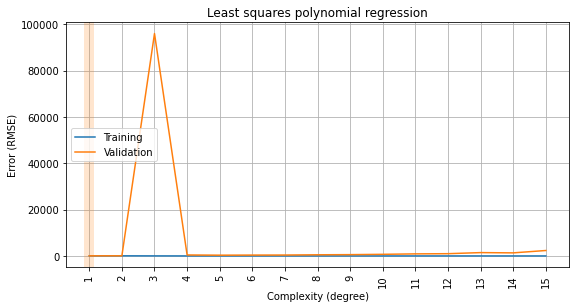

In [23]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train2, y_train2)
    rmse_train.append(rmse(reg.predict(X_train2), y_train2))
    rmse_valid.append(rmse(reg.predict(X_test2), y_test2))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

На степени 3 видно, что выскакивает очень большая ошибка. И из-за этого у оси у очень большие показатели, \
небольшие значения невооруженным взглядом не видны. Поэтому уберем из степеней 3/ и посмотрим, что будет

In [23]:
DEGREES = [ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]

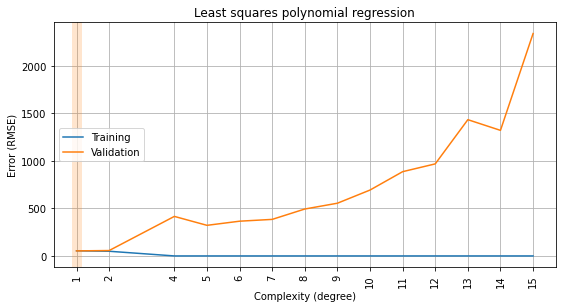

In [88]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train2, y_train2)
    rmse_train.append(rmse(reg.predict(X_train2), y_train2))
    rmse_valid.append(rmse(reg.predict(X_test2), y_test2))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

  это были графики без кросс-валидации, сделаем еще с ней, посмотрим разницу

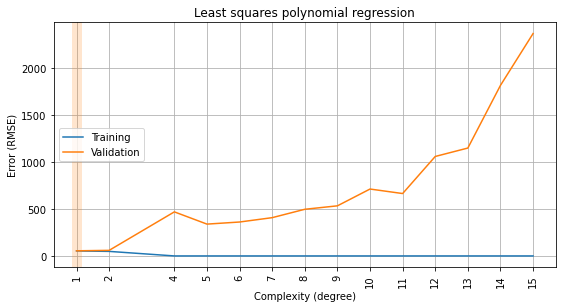

In [92]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_train2, y_train2, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

Наименьшая ошибка на тестовой выборке при степени 1, и примерно так же при степени 2. поэтому недообучения тут нету, \
а вот все что больше степени 2 - модель переобучается, т.е. ошибка на тренировочной выборке стремиться к нуля, \
в то время как на тестовой выборке увеличивается

Excercise 2 - Magnitude (3 points)\
As discussed earlier, regularization methods are expected to constraint the weights (model coefficients).\

Is it indeed happening?\

Please do a discovery on your own and find that out empirically (both for L1 and L2). Let's use degree=15 \
and alpha from ALPHAS.\

L1

Сначала взяла одну фичу, полиномизировала ее, и присоединила к остальному датафрэйму.\
Также переопределила функцию def make_model, чтобы увеличить количество  итераций

In [24]:
poly= PolynomialFeatures(15, include_bias=False)
feature=X_train2['bmi'].to_numpy()
feature=np.reshape(feature, (-1, 1))
feature=poly.fit_transform(X=feature)
ind=np.array(X_train2.index.values.tolist())
new=pd.DataFrame(feature, columns = [str(i) for i in range(feature.shape[1])])
new['ind']=ind.tolist()
new=new.set_index('ind')
result = pd.concat([new,X_train2 ], axis=1)
result_train=result.drop('0',axis=1)

In [25]:
poly= PolynomialFeatures(15, include_bias=False)
feature=X_test2['bmi'].to_numpy()
feature=np.reshape(feature, (-1, 1))
feature=poly.fit_transform(X=feature)
ind=np.array(X_test2.index.values.tolist())
new=pd.DataFrame(feature, columns = [str(i) for i in range(feature.shape[1])])
new['ind']=ind.tolist()
new=new.set_index('ind')
result = pd.concat([new,X_test2 ], axis=1)
result_test=result.drop('0',axis=1)

In [26]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=1000000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=1000000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias= (degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

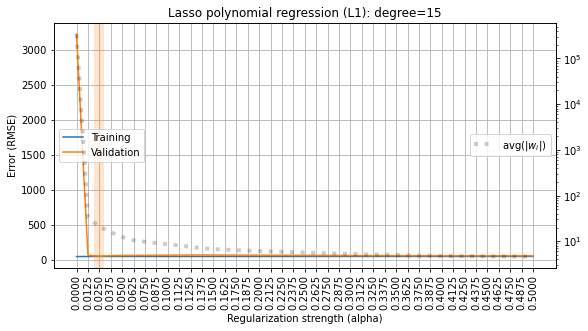

In [27]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS: 
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha ),
                             result_train, y_train2, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

Тут тоже можно видеть что за счет огромной ошибки при альфа равной 0 у оси у большие деления.\
для наглядности уберем из альфа 0

In [31]:
ALPHAS = np.linspace(0.0125, 0.5, 1 + 39)

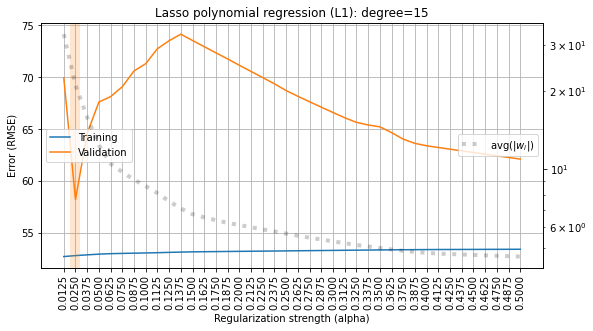

In [32]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS: 
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha ),
                             result_train, y_train2, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

L2

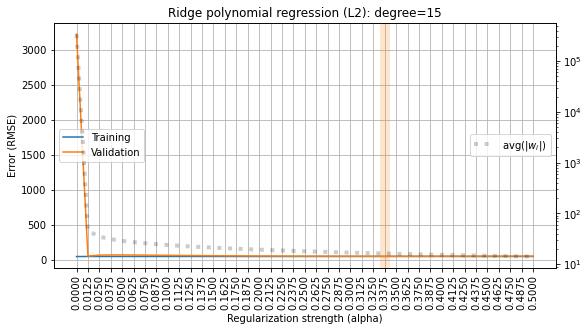

In [28]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS: 
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha ),
                             result_train, y_train2, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

Аналогично, уберем из альфа 0

In [29]:
ALPHAS = np.linspace(0.0125, 0.5, 1 + 39)

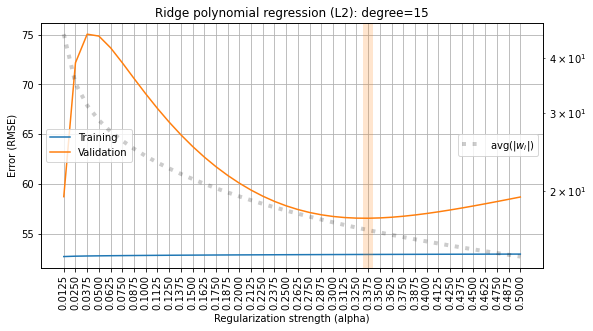

In [30]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS: 
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha ),
                             result_train, y_train2, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

Summary\
На графиках видно, что сумма весов на самом деле уменьшается с ростом альфа

Excercise 3 - Sparsity (3 points)\
Lasso can also be used for feature selection since L1 is more likely to produce zero coefficients.\

Is it indeed happening?\

Please do a discovery on your own and find that out empirically (both for L1 and L2). Let's use degree=15\
and alpha from ALPHAS.\

L1

Для каждого значения альфы я вывела коэффициенты, поместила в датафрэйм и посчитала количество нулей при  
каждом значении альфа. Сначала для лассо, потом Ridge. Видно что с увеличением альфа количество весов, которые \
равны нулю увеличивается в Лассо регрессии. Для альфа 0.5 например, количество нулей 20. в  Ridge нулей нет вообще

In [54]:
ALPHAS = np.linspace(0, 0.5, 1 + 40)
for alpha in ALPHAS: 
    model = Lasso(alpha=alpha)
    model.fit(result_train, y_train2)
    if alpha==0:
        list1 = model.coef_
    else:
        list1=np.vstack((list1,model.coef_))
        
df = pd.DataFrame(list1)
df[df == 0].count(axis=1)

C:\Users\YK\AppData\Local\Temp/ipykernel_16984/175302809.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(result_train, y_train2)
C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.395e+05, tolerance: 1.900e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0      0
1     13
2     15
3     15
4     15
5     15
6     16
7     17
8     17
9     17
10    17
11    17
12    17
13    17
14    18
15    18
16    19
17    19
18    19
19    19
20    19
21    19
22    19
23    19
24    19
25    19
26    19
27    19
28    20
29    20
30    20
31    20
32    20
33    20
34    20
35    20
36    20
37    20
38    20
39    20
40    20
dtype: int64

In [50]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-5928.104707,-46717.443518,1.666948e+06,3.289170e+06,-6.145124e+07,-3.489441e+07,-1.236731e+09,2.151661e+08,-6.957008e+09,7.098555e+10,...,63.637676,-262.733312,542.204327,386.671275,-789.993181,458.787473,53.596986,247.623923,631.130948,53.866180
1,766.218354,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,39.872397,-246.690626,526.159260,379.716791,-354.592696,93.656751,-116.018833,202.373838,455.451386,46.026651
2,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,22.177411,-236.132221,561.007776,372.336560,-226.688098,0.000000,-171.091147,168.942804,407.026075,43.411012
3,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,15.263401,-224.553232,560.923153,366.732138,-190.570904,-0.000000,-197.925292,127.027739,402.388874,41.132323
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.349465,-212.974218,560.838872,361.127893,-154.459013,-0.000000,-224.752832,85.119651,397.752296,38.853707
5,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.434765,-201.395461,560.751087,355.521836,-118.292837,-0.000000,-251.647982,43.140162,393.109337,36.574339
6,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-190.442946,560.503615,348.984055,-83.038598,-0.000000,-278.717062,1.811696,387.804434,33.682210
7,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-181.802182,559.730551,344.118161,-70.405871,-0.000000,-277.035222,0.000000,380.399304,29.669542
8,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-173.272342,558.935377,339.356707,-58.722621,-0.000000,-274.114012,0.000000,372.842214,25.585492
9,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-164.733252,558.155469,334.595395,-47.046392,-0.000000,-271.182378,0.000000,365.285529,21.499106


In [55]:
ALPHAS = np.linspace(0, 0.5, 1 + 40)
for alpha in ALPHAS: 
    clf = Ridge(alpha=alpha)
    clf.fit(result_train, y_train2)
    if alpha==0:
        list1 = clf.coef_
    else:
        list1=np.vstack((list1,clf.coef_))
        
df1 = pd.DataFrame(list1)
df1[df1 == 0].count(axis=1)
        

C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.82625e-36): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
dtype: int64

In [56]:
df1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,29705.322659,4396.771079,-2.513205e+07,-9.048122e+08,9.564687e+09,5.126469e+11,-3.178784e+12,-1.127955e+14,7.824273e+14,1.052350e+16,...,50.893602,-243.119197,1291.037404,352.952710,-625.629029,310.681328,7.008911,237.433188,604.860512,68.641329
1,391.834688,37.927560,7.504537e+00,9.354067e-01,1.479334e-01,2.092887e-02,3.231994e-03,4.879434e-04,7.613455e-05,1.186306e-05,...,40.634639,-251.856106,533.764036,378.081136,-357.673708,95.422222,-122.426970,202.349649,448.279060,52.367894
2,222.207482,22.140828,4.165584e+00,5.210661e-01,8.135614e-02,1.148954e-02,1.763858e-03,2.655196e-04,4.127807e-05,6.415228e-06,...,39.460082,-245.501068,535.864092,371.338223,-242.629292,8.133663,-169.757437,185.925152,399.898299,57.457655
3,159.080036,16.332104,2.948511e+00,3.706136e-01,5.725804e-02,8.082196e-03,1.235340e-03,1.856520e-04,2.879117e-05,4.467706e-06,...,39.351302,-239.558949,532.171673,365.591966,-191.329086,-27.535084,-189.532573,177.269889,377.182628,61.733980
4,125.994894,13.290479,2.315598e+00,2.924409e-01,4.476189e-02,6.317088e-03,9.619225e-04,1.443786e-04,2.234522e-05,3.463284e-06,...,39.503478,-233.921865,526.938910,360.312032,-161.729334,-45.990894,-199.783660,171.653554,363.123704,65.538680
5,105.557313,11.407400,1.926440e+00,2.443763e-01,3.709233e-02,5.234334e-03,7.943718e-04,1.191033e-04,1.840068e-05,2.848994e-06,...,39.751015,-228.540179,521.168885,355.342652,-142.120571,-56.680269,-205.624129,167.590785,353.045316,68.992020
6,91.633221,10.119541,1.662224e+00,2.117312e-01,3.189260e-02,4.500516e-03,6.809193e-04,1.019974e-04,1.573269e-05,2.433690e-06,...,40.038517,-223.384918,515.216634,350.615350,-127.949587,-63.238878,-209.069091,164.449781,345.144594,72.154960
7,81.505755,9.178268,1.470613e+00,1.880428e-01,2.812658e-02,3.969161e-03,5.988400e-04,8.962722e-05,1.380435e-05,2.133636e-06,...,40.342241,-218.435940,509.236138,346.091972,-117.076026,-67.359516,-211.076147,161.909468,338.579420,75.066232
8,73.786267,8.456764,1.324951e+00,1.700211e-01,2.526713e-02,3.565793e-03,5.365848e-04,8.024836e-05,1.234308e-05,1.906337e-06,...,40.650378,-213.677664,503.302425,341.747682,-108.360397,-69.934755,-212.159410,159.786631,332.903390,77.754048
9,67.690893,7.883533,1.210226e+00,1.558148e-01,2.301768e-02,3.248523e-03,4.876606e-04,7.288052e-05,1.119571e-05,1.727925e-06,...,40.956470,-209.097224,497.454512,337.564529,-101.139821,-71.478597,-212.619680,157.967857,327.857360,80.240707


Excercise 4 - Scaling (2 points)\
As a general rule, it is recommended to scale input features before fitting a regularized model so that the\
features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is\
exactly what our pipeline second step (StandardScaler) is responsible for.\

Is scaling important? What are the underlying reasons?\

Please do a discovery on your own and find that out empirically (both for L1 and L2) on the dataset below.\
Check coefficients.

In [73]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')


Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

In [75]:
# выведу значения весов при разных альфа
ALPHAS = np.linspace(0, 0.5, 1 + 40)
for alpha in ALPHAS: 
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    print(model.coef_, model.intercept_ )

[ 1.76505118e+02 -1.04041150e-03 -2.67273504e-02] 2.09137710748443
[ 1.62742716e+02 -1.07195979e-03 -2.73321710e-02] 2.085994868402228
[ 1.48980317e+02 -1.10350832e-03 -2.79369913e-02] 2.0806126491621635
[ 1.35217918e+02 -1.13505686e-03 -2.85418117e-02] 2.0752304299220983
[ 1.21455518e+02 -1.16660540e-03 -2.91466320e-02] 2.0698482106820313
[ 1.07693119e+02 -1.19815393e-03 -2.97514524e-02] 2.064465991441966
[ 9.39307201e+01 -1.22970247e-03 -3.03562728e-02] 2.0590837722019
[ 8.01683210e+01 -1.26125100e-03 -3.09610931e-02] 2.053701552961834
[ 6.64059218e+01 -1.29279954e-03 -3.15659135e-02] 2.0483193337217696
[ 5.26435226e+01 -1.32434807e-03 -3.21707338e-02] 2.0429371144817026
[ 3.88811235e+01 -1.35589661e-03 -3.27755542e-02] 2.0375548952416382
[ 2.51187243e+01 -1.38744514e-03 -3.33803746e-02] 2.032172676001572
[ 1.13563251e+01 -1.41899368e-03 -3.39851949e-02] 2.026790456761506
[ 0.         -0.00144501 -0.03448341] 2.0222575957533975
[ 0.         -0.00144491 -0.03447846] 2.0217313698631845

C:\Users\YK\AppData\Local\Temp/ipykernel_16984/1016959408.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X_train, y_train)
C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+02, tolerance: 1.685e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


C:\Users\YK\AppData\Local\Temp/ipykernel_16984/2343426788.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  clf.fit(X_train, y_train)
C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\YK\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+02, tolerance: 1.685e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


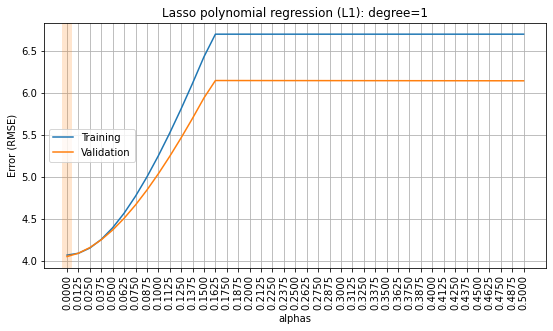

In [78]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:
    clf = Lasso(alpha=alpha)
    clf.fit(X_train, y_train)
    rmse_train.append(rmse(clf.predict(X_train), y_train))
    rmse_valid.append(rmse(clf.predict(X_test), y_test))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, xlabel='alphas', ylabel='Error (RMSE)', 
                   title='Lasso polynomial regression (L1): degree=1')

In [79]:
# тоже самое для Ridge
for alpha in ALPHAS: 
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    print(clf.coef_, clf.intercept_ )

[ 1.76505118e+02 -1.04041150e-03 -2.67273504e-02] 2.0913771074844307
[ 1.26687735e+02 -1.15497165e-03 -2.89345901e-02] 2.073798245967671
[ 9.88016368e+01 -1.21909858e-03 -3.01701266e-02] 2.0639579655661846
[ 8.09771962e+01 -1.26008772e-03 -3.09598641e-02] 2.057667999191592
[ 6.86011201e+01 -1.28854780e-03 -3.15082024e-02] 2.0533005197679026
[ 5.95064986e+01 -1.30946184e-03 -3.19111503e-02] 2.0500909206138083
[ 5.25410064e+01 -1.32547973e-03 -3.22197635e-02] 2.047632597088916
[ 4.70353195e+01 -1.33814065e-03 -3.24636975e-02] 2.045689374321543
[ 4.25740535e+01 -1.34839982e-03 -3.26613566e-02] 2.044114681505244
[ 3.88857667e+01 -1.35688144e-03 -3.28247675e-02] 2.042812738880671
[ 3.57855808e+01 -1.36401067e-03 -3.29621217e-02] 2.041718311034553
[ 3.31432219e+01 -1.37008708e-03 -3.30791910e-02] 2.040785430133199
[ 3.08642476e+01 -1.37532785e-03 -3.31801599e-02] 2.039980771593603
[ 2.88785202e+01 -1.37989427e-03 -3.32681361e-02] 2.0392795869098226
[ 2.71328607e+01 -1.38390862e-03 -3.3345475

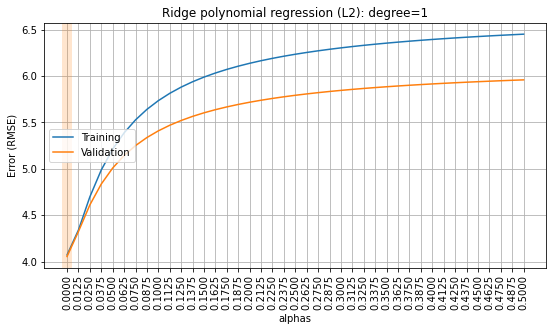

In [80]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    rmse_train.append(rmse(clf.predict(X_train), y_train))
    rmse_valid.append(rmse(clf.predict(X_test), y_test))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, xlabel='alphas', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=1')

Summary\
на графикам явно видно, что наилучшие результаты при альфа == 0, т е при отсутствии регуляризации. Наверное, это \
связано с тем, что при регуляризации модель старается найти в том числе наименьшую сумму весов, (или сумму квадратов\
весов), и при данных не нормированных, веса получаются очень разнонаправленными по знаку и большими по модулю, это видно из выведенных коэффициентов. Поэтому сумма весов может уменьшится в большей степени, и модель с регуляризацией\
уменьшает веса, но при этом страдает точность предсказания